<h1> Feature Engineering </h1>

This notebook is Lab4a of CPB 102, Google's course on Machine Learning using Cloud ML.

This notebook demonstrates:
<ol>
<li> Reading data from BigQuery </li>
<li> Carrying out preprocessing using the ML SDK </li>
<li> Adding feature crosses in TensorFlow </li>
</ol> 

<div id="toc"></div>

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [4]:
import google.cloud.ml as ml
import tensorflow as tf
print tf.__version__
print ml.sdk_location

0.11.0rc0
gs://cloud-ml/sdk/cloudml-0.1.6-alpha.dataflow.tar.gz


<h2> Benchmark </h2>

This is a simple linear model.  I will use exactly this input as the input to the Cloud ML model.  I would expect the Cloud ML model to learn this weight (372) and get somewhere around this RMSE.

It doesn't.

Rate = $327.930548824/deg
Train RMSE = 7.07314793321
Valid RMSE = 6.12883892713
Test RMSE = 5.73314396481


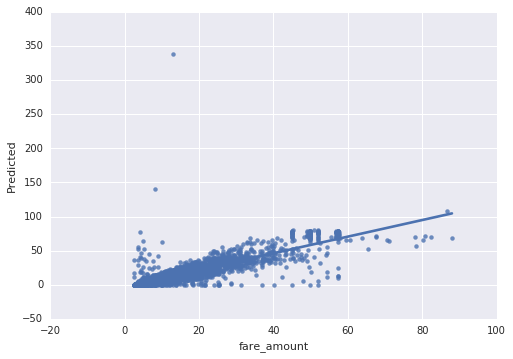

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

def distance_between(lat1, lon1, lat2, lon2):
  # haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  #dist = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
  dist = np.sqrt( np.square(lon2-lon1) + np.square(lat2-lat1) )
  return dist

def estimate_distance(df):
  return distance_between(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

def print_rmse(df, rate, name):
  print "{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate*estimate_distance(df)), name)

def read_dataset(filename):
  return pd.read_csv(filename, header=None, names=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count', 'fare_amount'])

df_train = read_dataset('../lab1a/taxi-train.csv')
df_valid = read_dataset('../lab1a/taxi-valid.csv')
df_test = read_dataset('../lab1a/taxi-test.csv')
  
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print "Rate = ${0}/deg".format(rate)
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

ax = sns.regplot(x=df_train['fare_amount'], y=rate*estimate_distance(df_train), ci=None, truncate=True)
ax.set_ylabel('Predicted')

<h1> Specifying query to pull the data </h1>

The full dataset is 1 billion rows. For experimentation, let's sample it to create 10,000 samples.
Later, we'll remove the limit and train on the full dataset.
We're also using BigQuery sampling to pull out independent training and validation samples.  This is the same query as was used to the create the .csv files above.

In [5]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT
  DAYOFWEEK(pickup_datetime)*1.0 AS dayofweek,
  HOUR(pickup_datetime)*1.0 AS hourofday,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count*1.0 AS passenger_count,
  (tolls_amount + fare_amount) as fare_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
    trip_distance > 0
    AND fare_amount >= 2.5
    AND pickup_longitude > -78
    AND pickup_longitude < -70
    AND dropoff_longitude > -78
    AND dropoff_longitude < -70
    AND pickup_latitude > 37
    AND pickup_latitude < 45
    AND dropoff_latitude > 37
    AND dropoff_latitude < 45
    AND passenger_count > 0 
  """

  if EVERY_N == None:
    if phase < 2:
      # training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)

  
    
  return query
    
print create_query(2, 100000)


SELECT
  DAYOFWEEK(pickup_datetime)*1.0 AS dayofweek,
  HOUR(pickup_datetime)*1.0 AS hourofday,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count*1.0 AS passenger_count,
  (tolls_amount + fare_amount) as fare_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
    trip_distance > 0
    AND fare_amount >= 2.5
    AND pickup_longitude > -78
    AND pickup_longitude < -70
    AND dropoff_longitude > -78
    AND dropoff_longitude < -70
    AND pickup_latitude > 37
    AND pickup_latitude < 45
    AND dropoff_latitude > 37
    AND dropoff_latitude < 45
    AND passenger_count > 0 
   AND ABS(HASH(pickup_datetime)) % 100000 == 2


Try the query above in https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips if you want to see what it does (ADD LIMIT 10 to the query!)

<h2> Preprocessing features using Cloud ML SDK </h2>

We could discretize the lat-lon columns using the SDK, but we'll defer that to TensorFlow to enable it to be a hyper-parameter if necessary.

In [9]:
import google.cloud.ml.features as features

import google.cloud.ml as ml
print ml.sdk_location

class TaxifareFeatures(object):
  csv_columns = ('dayofweek', 'hourofday', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount')
  fare_amount = features.target('fare_amount').continuous()
  pcount = features.numeric('passenger_count').identity()
  plat = features.numeric('pickup_latitude').identity()
  dlat = features.numeric('dropoff_latitude').identity()
  plon = features.numeric('pickup_longitude').identity()
  dlon = features.numeric('dropoff_longitude').identity()
  dayofweek = features.numeric('dayofweek').identity()
  hourofday = features.numeric('hourofday').identity()

gs://cloud-ml/sdk/cloudml-0.1.6-alpha.dataflow.tar.gz


<h2> Preprocessing Dataflow job from BigQuery </h2>

This code reads from BigQuery and runs the above preprocessing, saving the data on Google Cloud.  Make sure to change the BUCKET and PROJECt variable to be yours.

If you are running on the Cloud, you should go to the GCP Console to look at the status of the job. If you are running locally, you'll get a Running bar and it will take up to 5 minutes.

In [10]:
%bash
BUCKET=cloud-training-demos-ml
gsutil -m rm -r -f gs://$BUCKET/taxifare/taxi_preproc4a

CommandException: 1 files/objects could not be removed.


In [11]:
# imports
import apache_beam as beam
import google.cloud.ml as ml
import google.cloud.ml.dataflow.io.tfrecordio as tfrecordio
import google.cloud.ml.io as io
import os
import datetime

# Change as needed
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
EVERY_N = 50 * 1000 # Change this to None to preprocess full dataset

# Direct runs locally; Dataflow runs on the Cloud.
RUNNER = 'DirectPipelineRunner'
#RUNNER = 'DataflowPipelineRunner'

OUTPUT_DIR = 'gs://{0}/taxifare/taxi_preproc4a/'.format(BUCKET)
options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S'),
    'project': PROJECT,
    'extra_packages': [ml.sdk_location],
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'no_save_main_session': True
}
opts = beam.pipeline.PipelineOptions(flags=[], **options)
pipeline = beam.Pipeline(RUNNER, options=opts)

# defines
feature_set = TaxifareFeatures()
train_query = create_query(1, EVERY_N)
valid_query = create_query(2, EVERY_N)
train = pipeline | 'read_train' >> beam.Read(beam.io.BigQuerySource(query=train_query))
eval = pipeline | 'read_valid' >> beam.Read(beam.io.BigQuerySource(query=valid_query))

(metadata, train_features, eval_features) = ((train, eval) |
   'Preprocess' >> ml.Preprocess(feature_set))

(metadata
   | 'SaveMetadata'
   >> io.SaveMetadata(os.path.join(OUTPUT_DIR, 'metadata.yaml')))
(train_features
   | 'WriteTraining'
   >> io.SaveFeatures(os.path.join(OUTPUT_DIR, 'features_train')))
(eval_features
   | 'WriteEval'
   >> io.SaveFeatures(os.path.join(OUTPUT_DIR, 'features_eval')))

# run pipeline
pipeline.run()

In [12]:
!gsutil ls gs://cloud-training-demos-ml/taxifare/taxi_preproc4a/

gs://cloud-training-demos-ml/taxifare/taxi_preproc4a/features_eval-00000-of-00001.tfrecord.gz
gs://cloud-training-demos-ml/taxifare/taxi_preproc4a/features_train-00000-of-00001.tfrecord.gz
gs://cloud-training-demos-ml/taxifare/taxi_preproc4a/metadata.yaml


In [13]:
%bash
gsutil cp -R gs://cloud-training-demos-ml/taxifare/taxi_preproc4a /content/training-data-analyst/CPB102/lab4a

Copying gs://cloud-training-demos-ml/taxifare/taxi_preproc4a/features_eval-00000-of-00001.tfrecord.gz...
Copying gs://cloud-training-demos-ml/taxifare/taxi_preproc4a/features_train-00000-of-00001.tfrecord.gz...
Copying gs://cloud-training-demos-ml/taxifare/taxi_preproc4a/metadata.yaml...
- [3 files][  1.1 MiB/  1.1 MiB]                                                
Operation completed over 3 objects/1.1 MiB.                                      


<h2> 3. Training </h2>

Training requires you to package up your TensorFlow model into a Python package. We've done this in the directory 'taxifare'

In that code, the latitude and longitude are discretized, and feature-crossed. The hourofday and dayofweek are divided into buckets that reflect typical traffic patterns.  The whole model is then trained.

In [14]:
%bash
grep -A 40 create_inputs taxifare/trainer/taxifare.py

def create_inputs(metadata, input_data=None):
  with tf.name_scope('inputs'):
    if input_data is None:
      input_data = tf.placeholder(tf.string, name='input', shape=(None,))
    parsed = features.FeatureMetadata.parse_features(metadata, input_data)

    # [batchsize, 1] 
    plat = parsed['plat']
    plon = parsed['plon']
    dlat = parsed['dlat']
    dlon = parsed['dlon']
    dist_cyl = 1000*tf.sqrt( tf.square(tf.sub(plat, dlat)) + tf.square(tf.sub(plon, dlon)) )

    inputs = dist_cyl
    print 'inputs=',inputs.get_shape().as_list()
    return (input_data, inputs, tf.squeeze(parsed['fare_amount']),
            _create_fakekey(input_data)) # no key tf.identity(parsed['key']))

def inference(inputs, metadata, hyperparams):
  input_size = 1
  output_size = metadata.features['fare_amount']['size']
  
  inputs = tf.Print(inputs, data=[inputs], message='INPUT VALUES = ', first_n=5)
  nnoutput = tf.contrib.layers.fully_connected(inputs, output_size, activation_fn=None,
                

In [15]:
%bash
rm -rf taxifare.tar.gz taxi_trained
tar cvfz taxifare.tar.gz taxifare

taxifare/
taxifare/PKG-INFO
taxifare/setup.cfg
taxifare/trainer.egg-info/
taxifare/trainer.egg-info/PKG-INFO
taxifare/trainer.egg-info/top_level.txt
taxifare/trainer.egg-info/dependency_links.txt
taxifare/trainer.egg-info/SOURCES.txt
taxifare/trainer/
taxifare/trainer/task.py
taxifare/trainer/taxifare.py
taxifare/trainer/__init__.py
taxifare/setup.py


In [ ]:
%%mlalpha train
package_uris: /content/training-data-analyst/CPB102/lab4a/taxifare.tar.gz
python_module: trainer.task
scale_tier: BASIC
region: us-central1
args:
  train_data_paths: /content/training-data-analyst/CPB102/lab4a/taxi_preproc4a/features_train*
  eval_data_paths: /content/training-data-analyst/CPB102/lab4a/taxi_preproc4a/features_eval*
  metadata_path: /content/training-data-analyst/CPB102/lab4a/taxi_preproc4a/metadata.yaml
  output_path: /content/training-data-analyst/CPB102/lab4a/taxi_trained
  max_steps: 1000

Job Running...

master log

master: master: I tensorflow/core/kernels/logging_ops.cc:79] INPUT VALUES = [9.3453856 8.7167168 16.010223...] master: I tensorflow/core/kernels/logging_ops.cc:79] PRED VALUES = [-1.5705416 -1.4543487 -2.8023622...] master: I tensorflow/core/kernels/logging_ops.cc:79] INPUT VALUES = [8.7725191 9.8011827 18.678318...] master: I tensorflow/core/kernels/logging_ops.cc:79] PRED VALUES = [-1.4646623 -1.6547838 -3.2954895...] master: INFO:root:Eval, step 856: rmse = 16.806 master: master: INFO:root:Step 900: loss = 21.47 (0.068 sec) master: master: INFO:root:Step 1000: loss = 23.17 (0.069 sec) master: I tensorflow/core/kernels/logging_ops.cc:79] INPUT VALUES = [9.3453856 8.7167168 16.010223...] master: I tensorflow/core/kernels/logging_ops.cc:79] PRED VALUES = [-1.4553337 -1.346082 -2.6135678...] master: I tensorflow/core/kernels/logging_ops.cc:79] INPUT VALUES = [8.7725191 9.8011827 18.678318...] master: I tensorflow/core/kernels/logging_ops.cc:79] PRED VALUES = [-1.3557794 -1.5345434 -3.0772367...] master: INFO:root:Final rmse after 1000 steps = 16.367 master: INFO:root:Done training. master: inputs= [1024, 1] master: inputs= [1024, 1] master: inputs= [None, 1] master:

Job Finished.

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License